# official and unofficial tpf

Unofficial using TPF of EPIC249622103 in K2-C15

* [paper](https://arxiv.org/abs/1803.05056)

In [1]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
from astropy.io import fits
import pandas as pd
from astropy.io import fits

Difference between official and unofficial tpf

In [2]:
official = 'https://archive.stsci.edu/pub/k2/eng/long_cadence/kplr060021426-2014044044430_lpd-targ.fits'
fits.open(official)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa5fba514a8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa5fb9fdb00>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa5fa8eec18>]

In [3]:
from lightkurve import KeplerTargetPixelFile

tpf_official=KeplerTargetPixelFile(official)

In [4]:
tpf_official = KeplerTargetPixelFile('2014044044430.fits')

The aperture mask used by the Kepler pipeline is `hdulist[-1].data > 2`. This is also implemented in `lightkurve.`

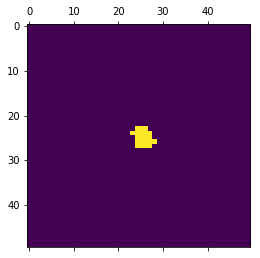

In [5]:
mask = tpf_official.hdu[-1].data > 2
pl.matshow(mask)

However, the unofficial do not have a proper pipeline mask

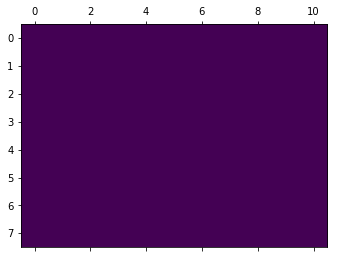

In [6]:
unofficial = 'ktwo249622103-unofficial-tpf.fits'
default_pipeline_mask = fits.open(unofficial)[-1].data > 2
pl.matshow(default_pipeline_mask)

In [7]:
from lightkurve import KeplerTargetPixelFile

tpf_unofficial=KeplerTargetPixelFile(unofficial)

In [8]:
tpf_official.properties()

   Attribute              Description           
--------------- --------------------------------
       campaign                               -1
        channel                               28
         column                               43
       keplerid                         60021426
         module                                9
         output                                4
            row                              876
           path               2014044044430.fits
quality_bitmask                          default
            hdu  PRIMARY, TARGETTABLES, APERTURE
      cadenceno                     array (435,)
           flux              array (435, 50, 50)
       flux_bkg              array (435, 50, 50)
   flux_bkg_err              array (435, 50, 50)
       flux_err              array (435, 50, 50)
  nan_time_mask                     array (435,)
  pipeline_mask                   array (50, 50)
      pos_corr1                     array (435,)
      pos_corr2     

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


In [9]:
tpf_unofficial.properties()

   Attribute               Description           
--------------- ---------------------------------
        channel                                63
         column                               933
       keplerid                         249622103
         module                                18
         output                                 3
            row                              1005
       campaign                              None
            dec                              None
        mission                                K2
           path ktwo249622103-unofficial-tpf.fits
quality_bitmask                           default
             ra                              None
            hdu   PRIMARY, TARGETTABLES, APERTURE
      cadenceno                     array (4305,)
           flux               array (4305, 8, 11)
       flux_bkg               array (4305, 8, 11)
   flux_bkg_err               array (4305, 8, 11)
       flux_err               array (4305, 8, 11)


## rec arrays

In [10]:
tpf_official.hdu[1].data.shape

(440,)

## Generating lightcurves

In [11]:
from lightkurve import KeplerTargetPixelFile

tpf = KeplerTargetPixelFile(unofficial) #, quality_bitmask='hardest')
lc = tpf.to_lightcurve(aperture_mask='all');
lc = lc.remove_nans().remove_outliers(sigma=3.5)

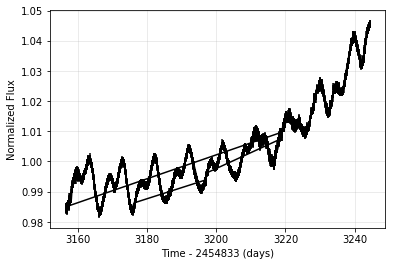

In [12]:
lc.plot(linestyle='solid');

Note: using all pixels is not ideal. Let's try pipeline mask.

In [13]:
tpf.to_lightcurve(aperture_mask='pipeline')

KeplerLightCurve(EPIC: None)

Note: aperture mask is null!

In [14]:
tpf.pipeline_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False]])

## Using van Eylen's `find_aperture`

In [15]:
from matplotlib.colors import LogNorm
from scipy.ndimage import measurements
import os

cmap='viridis'

def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
    ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

def find_aperture(dates,fluxes,starname='',outputfolder='',kepmag='na',cutoff_limit=1.,showfig=None):
    #
    # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
    #

    # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    #if showfig: # make aperture figure
    pl.figure('Aperture_' + str(starname))
    pl.imshow(flux,norm=LogNorm(),interpolation="none",cmap=cmap)
    pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
    pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))
    #pl.colorbar(orientation='vertical')
    pl.xlabel('X',fontsize=15)
    pl.ylabel('Y',fontsize=15)
    #pl.legend()
    #pl.xlim([-1,18])
    #pl.ylim([-1,16])
    #pl.xticks([0,5,10,15])
    #pl.yticks([0,5,10,15])
    pl.tight_layout()
    #pl.savefig(os.path.join(outputfolder,'aperture_' + str(starname)+'.pdf'))
    #pl.close()
    #pl.show()
    return np.array(aperture[0],dtype=bool)

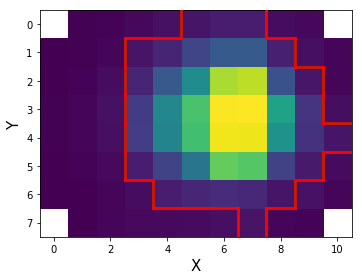

In [16]:
times = tpf.time
fluxes = tpf.flux
aperture = find_aperture(times,fluxes,starname=tpf.keplerid)

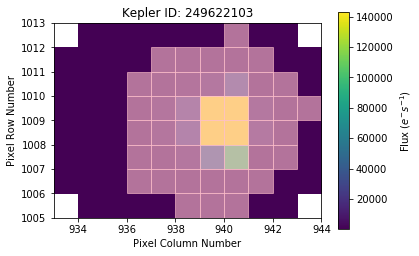

In [17]:
tpf.plot(aperture_mask=aperture)

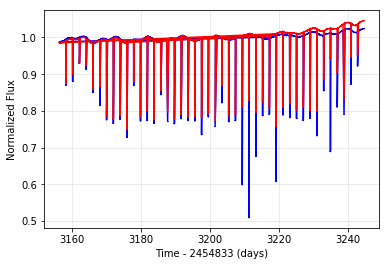

In [18]:
ax = tpf.to_lightcurve(aperture_mask=aperture).plot(color='b')
tpf.to_lightcurve(aperture_mask='all').plot(ax=ax, color='r')

In [19]:
lc2 = tpf.to_lightcurve(aperture_mask=aperture);
lc2 = lc2.remove_nans().remove_outliers(sigma=3.5)

In [20]:
lc2 = lc2.remove_nans().remove_outliers(sigma=3)
flat_lc2, trend = lc2.flatten(window_length=101, return_trend=True)

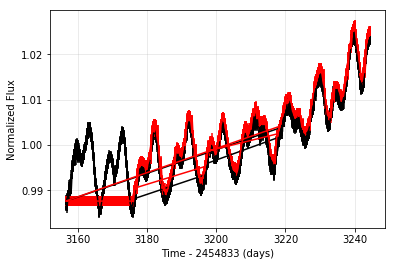

In [21]:
ax = lc2.plot()                         
trend.plot(ax, color='red');

In [22]:
import pandas as pd

def sort_vectors(lc):
    time = lc.time
    flux = lc.flux
    flux_err = lc.flux_err
    centroid_col = lc.centroid_col
    centroid_row = lc.centroid_row
    
    df = pd.DataFrame(np.c_[flux,flux_err,centroid_col,centroid_row],index=time)
    df = df.sort_index()
    df.columns = ['f', 'ferr', 'centroid_col', 'centroid_row']

    t_sort,f_sort,ferr_sort = df.index, df.f.values, df.ferr.values
    centroid_col_sort, centroid_row_sort = df.centroid_col.values, df.centroid_row.values

    lc.time = df.index.values
    lc.flux = df.f.values
    lc.flux_err = df.ferr.values
    
    return lc

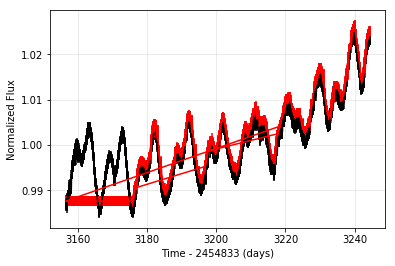

In [23]:
lc2 = sort_vectors(lc2)

ax = lc2.plot()                         
trend.plot(ax, color='red');

In [24]:
corr_lc = lc2.correct(windows=20)

100%|██████████| 20/20 [00:00<00:00, 26.87it/s]


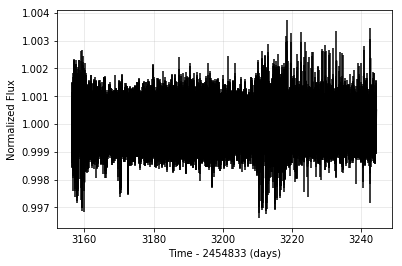

In [25]:
corr_lc.plot()

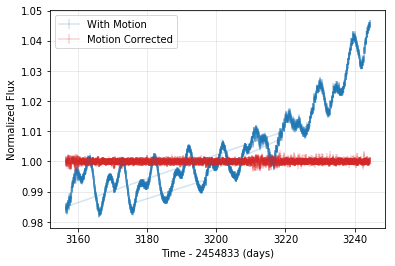

In [26]:
ax = lc.plot(color='C0', alpha=0.2, label='With Motion')
ax = corr_lc.plot(ax=ax, color='C3', alpha=0.2, label='Motion Corrected');